In [7]:
%pip install keras

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import ConvLSTM2D, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Flatten, Dense
from datetime import datetime
from datetime import timedelta
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.svm import SVR

In [14]:
T640 = pd.read_csv('Data/T640.csv')                  # Add "NaN" to null values
MET = pd.read_csv('Data/MET.csv')

In [15]:
Combined_df = T640.merge(MET, left_on="Timestamp (UTC+0)", right_on="Timestamp (UTC+0)", how="inner")

In [16]:
Combined_df["Timestamp (UTC+0)"] = pd.to_datetime(Combined_df["Timestamp (UTC+0)"])
Combined_df.sort_values("Timestamp (UTC+0)", ascending=True)
Combined_df.set_index("Timestamp (UTC+0)", inplace=True)


In [17]:
Combined_df.index

DatetimeIndex(['2024-09-27 10:00:00', '2024-09-27 09:00:00',
               '2024-09-27 08:00:00', '2024-09-27 07:00:00',
               '2024-09-27 06:00:00', '2024-09-27 05:00:00',
               '2024-09-27 04:00:00', '2024-09-27 03:00:00',
               '2024-09-27 02:00:00', '2024-09-27 01:00:00',
               ...
               '2021-04-02 01:00:00', '2021-04-02 00:00:00',
               '2021-04-01 23:00:00', '2021-04-01 22:00:00',
               '2021-04-01 21:00:00', '2021-04-01 20:00:00',
               '2021-04-01 19:00:00', '2021-04-01 18:00:00',
               '2021-04-01 17:00:00', '2021-04-01 16:00:00'],
              dtype='datetime64[ns]', name='Timestamp (UTC+0)', length=28801, freq=None)

In [83]:
Combined_df.columns

Index(['NowCast_PM10_AQI', 'NowCast_PM2.5_AQI', 'NowCastConc10',
       'NowCastConc25', 'PM10', 'PM25', 'RH', 'Temp', 'WD', 'WS'],
      dtype='object')

In [18]:
records_per_hour = Combined_df.groupby(Combined_df.index).size()
records_per_hour

Timestamp (UTC+0)
2021-04-01 16:00:00    1
2021-04-01 17:00:00    1
2021-04-01 18:00:00    1
2021-04-01 19:00:00    1
2021-04-01 20:00:00    1
                      ..
2024-09-27 06:00:00    1
2024-09-27 07:00:00    1
2024-09-27 08:00:00    1
2024-09-27 09:00:00    1
2024-09-27 10:00:00    1
Length: 28801, dtype: int64

In [20]:
def get_season(date):
    if date.month in [11, 12, 1, 2]:
        return 1
    elif date.month in [3,4]:
        return 2
    else:
        return 3

def prepare_data(df):
    df['Target'] = df['PM25']
    df.dropna(inplace=True)

    df['Hour'] = df.index.hour
    df['Hour'] = df['Hour'].shift(-1)
    df['PM10_lag1'] = df["PM10"].shift(-1)
    df['PM25_lag1'] = df["PM25"].shift(-1)
    df['PM10_AQI_lag1'] = df["NowCast_PM10_AQI"].shift(-1)
    df['PM2.5_AQI_lag1'] = df["NowCast_PM2.5_AQI"].shift(-1)
    df[['RH_lag1', 'Temp_lag1', 'WD_lag1', 'WS_lag1']] = df[['RH', 'Temp', 'WD', 'WS']].shift(-1)
    df['Season'] = [get_season(date) for date in df.index]
    df['Day'] = df.index.dayofweek
    df.sort_index(ascending=True)

    df.dropna(inplace=True)
    return df

prepare_data(Combined_df)

,NowCast_PM10_AQI,NowCast_PM2.5_AQI,NowCastConc10,NowCastConc25,PM10,PM25,RH,Temp,WD,WS,...,PM10_lag1,PM25_lag1,PM10_AQI_lag1,PM2.5_AQI_lag1,RH_lag1,Temp_lag1,WD_lag1,WS_lag1,Season,Day
Timestamp (UTC+0),,,,,,,,,,,,,,,,,,,,,
2024-09-27 10:00:00,55,43,32.0,11.9,25.92676,10.32331,85.3,29.72,256.8,0.380,...,25.70580,11.010650,63.0,46.0,93.70,28.20,269.0,0.401,3,4
2024-09-27 09:00:00,63,46,39.0,12.8,25.70580,11.01065,93.7,28.20,269.0,0.401,...,38.54116,12.804810,63.0,46.0,100.10,26.86,278.4,0.455,3,4
2024-09-27 08:00:00,63,46,39.0,12.8,38.54116,12.80481,100.1,26.86,278.4,0.455,...,55.02645,15.348110,43.0,36.0,100.60,25.33,286.9,0.539,3,4
2024-09-27 07:00:00,43,36,24.0,10.1,55.02645,15.34811,100.6,25.33,286.9,0.539,...,28.11204,12.119590,36.0,30.0,100.60,25.17,285.5,0.511,3,4
2024-09-27 06:00:00,36,30,20.0,8.3,28.11204,12.11959,100.6,25.17,285.5,0.511,...,20.31748,8.689554,36.0,29.0,100.60,25.55,269.2,0.509,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-01 22:00:00,173,157,299.0,66.3,312.81800,74.68478,90.0,28.91,200.0,1.092,...,283.81310,62.522050,180.0,158.0,89.80,29.18,191.4,1.224,2,3
2021-04-01 21:00:00,180,158,314.0,68.6,283.81310,62.52205,89.8,29.18,191.4,1.224,...,281.47650,61.589470,197.0,160.0,89.70,29.32,182.4,1.640,2,3
2021-04-01 20:00:00,197,160,347.0,72.9,281.47650,61.58947,89.7,29.32,182.4,1.640,...,294.82450,62.056770,243.0,163.0,87.60,29.57,169.3,2.314,2,3


In [62]:

X = Combined_df[['Hour', 'Day', 'PM25_lag1', 'RH_lag1', 'Temp_lag1', 'WD_lag1', 'WS_lag1','Season']]  # Add more features as needed
y = Combined_df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=66)



In [23]:
# from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score
# from sklearn.neighbors import KNeighborsClassifier
# # from sklearn.svm import SVC
# # # from sklearn.tree import DecisionTreeClassifier
# # # from xgboost import XGBClassifier


# def train_and_evaluate(Xtrain_reshaped, ytrain):
#     # Initialize the classifiers
#     regressors = [
#         # LogisticRegressor(),
#         RandomForestRegressor(),
#         DecisionTreeRegressor(),
#         KNeighborsRegressor(),
#         XGBRegressor(),
#         LGBMRegressor(),
#         SVR()
#     ]

#     # Train and evaluate each regressor
#     for regressor in regressors:
#         # Train the model
#         regressor.fit(Xtrain_reshaped, ytrain)

#         # Make predictions on the training set
#         ypred_train = regressor.predict(Xtrain_reshaped)

#         # Calculate regression metrics
#         rmse_train = rmse(ytrain, ypred_train)
#         r2_train = r2_score(ytrain, ypred_train)

#         # Perform 5-fold cross validation
#         scores = cross_val_score(regressor, Xtrain_reshaped, ytrain, cv=5, scoring='neg_mean_squared_error')
#         scores = -scores  # Convert to positive MSE

#         # Print cross-validation scores and training set metrics
#         print("Regressor:", regressor.__class__.__name__)
#         print("Cross-validation MSE scores: ", scores)
#         print('Training RMSE:', rmse_train)
#         print('Training R^2:', r2_train)
#         print()

# Reshaping the train
# Xtrain_reshaped = X_train.shape[0],(X_train.shape[1]*X_train.shape[2]))

# Calling the train and evaluation function ignoring the first columns which is the item Id
# train_and_evaluate(X_train, y_train)

In [63]:
# Making predictions using the RandomForest algorithm, the best model
rf = RandomForestRegressor()  # Change to RandomForestRegressor
rf.fit(X_train, y_train)  # Use the reshaped training data

rfpred = rf.predict(X_test)

# Metrics
rmse_ = rmse(y_test, rfpred)  # Mean Squared Error
r2 = r2_score(y_test, rfpred)  # R-squared

print('Root Mean Squared Error:')
print(rmse_)
print('R-squared:')
print(r2)
print()

Root Mean Squared Error:
6.346879717887539
R-squared:
0.9670106054572144



<Axes: xlabel='Timestamp (UTC+0)'>

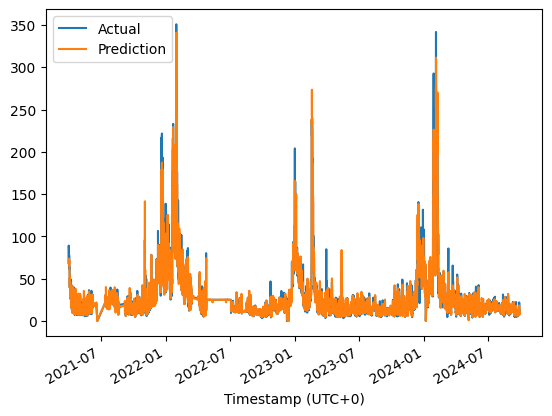

In [64]:
results = pd.DataFrame()

results["Actual"] = y_test
results["Prediction"] = rfpred

results.index = y_test.index

results.sort_index(inplace=True)

results.plot()


In [25]:
import joblib

joblib.dump(rf, "regression_model.joblib")

['regression_model.joblib']